In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
import tensorflow.keras

In [ ]:
vgg = tf.keras.applications.VGG19(include_top = False,weights = 'imagenet')
for layers in vgg.layers:
    print(f"{layers.name} -->  {layers.output_shape}")

input_12 -->  [(None, None, None, 3)]
block1_conv1 -->  (None, None, None, 64)
block1_conv2 -->  (None, None, None, 64)
block1_pool -->  (None, None, None, 64)
block2_conv1 -->  (None, None, None, 128)
block2_conv2 -->  (None, None, None, 128)
block2_pool -->  (None, None, None, 128)
block3_conv1 -->  (None, None, None, 256)
block3_conv2 -->  (None, None, None, 256)
block3_conv3 -->  (None, None, None, 256)
block3_conv4 -->  (None, None, None, 256)
block3_pool -->  (None, None, None, 256)
block4_conv1 -->  (None, None, None, 512)
block4_conv2 -->  (None, None, None, 512)
block4_conv3 -->  (None, None, None, 512)
block4_conv4 -->  (None, None, None, 512)
block4_pool -->  (None, None, None, 512)
block5_conv1 -->  (None, None, None, 512)
block5_conv2 -->  (None, None, None, 512)
block5_conv3 -->  (None, None, None, 512)
block5_conv4 -->  (None, None, None, 512)
block5_pool -->  (None, None, None, 512)


In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return gram_matrix/i_j 

In [ ]:
def load_vgg():
    vgg = tf.keras.applications.VGG19(include_top = False,weights = 'imagenet')
    vgg.trainable  = True
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
    content_output = vgg.get_layer(content_layers[0]).output
    style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]
    gram_style_output = [gram_matrix(_output) for _output in style_output]
    model = tf.keras.Model([vgg.inputs],[content_output,gram_style_output])
    return model


In [ ]:
opt = tf.optimizers.Adam(learning_rate = 0.001,beta_1 = 0.99,epsilon = 1e-1)

In [ ]:
def loss_function(style_output,content_output,style_target,content_target):
    style_weight = 1000
    content_weight = 1e-3
    style_loss = sum([tf.reduce_mean((output_-target_)**2) for output_,target_ in zip(style_output,style_target)])
    content_loss = tf.reduce_mean((content_output-content_target)**2)
    total_loss = content_weight*content_loss + style_weight*style_loss
    return total_loss                  

AxesImage(54,36;334.8x217.44)


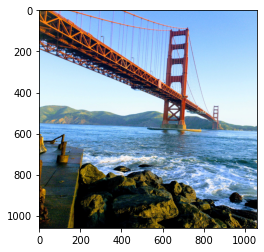

In [ ]:
vgg_model = load_vgg()
content_image = cv2.resize(cv2.imread('GoldenGate.jpg'),(1060,1060))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image =  cv2.resize(cv2.imread('starry_night.jpg'),(1060,1060))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]
content_image = cv2.cvtColor(np.array(content_image),cv2.COLOR_BGR2RGB)
style_image = cv2.cvtColor(np.array(style_image),cv2.COLOR_BGR2RGB)
print(plt.imshow(content_image))

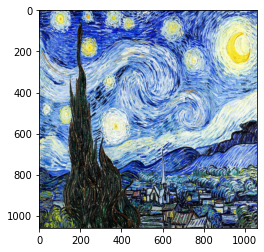

In [ ]:
plt.imshow(style_image)

In [ ]:
import sys
def train_step(image,epoch,total_epoch):
    with tf.GradientTape() as tape:
        output = vgg_model(image*255)
        loss = loss_function(output[1], output[0], style_target, content_target)
    gradient = tape.gradient(loss, image)
    opt.apply_gradients([(gradient, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
    
    print(f'{(epoch/total_epoch)*100} % completed')
    sys.stdout.flush()
        

In [ ]:
EPOCHS = 1000
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
    train_step(image, i,EPOCHS)

0.0 % completed
0.1 % completed
0.2 % completed
0.3 % completed
0.4 % completed
0.5 % completed
0.6 % completed
0.7000000000000001 % completed
0.8 % completed
0.8999999999999999 % completed
1.0 % completed
1.0999999999999999 % completed
1.2 % completed
1.3 % completed
1.4000000000000001 % completed
1.5 % completed
1.6 % completed
1.7000000000000002 % completed
1.7999999999999998 % completed
1.9 % completed
2.0 % completed
2.1 % completed
2.1999999999999997 % completed
2.3 % completed
2.4 % completed
2.5 % completed
2.6 % completed
2.7 % completed
2.8000000000000003 % completed
2.9000000000000004 % completed
3.0 % completed
3.1 % completed
3.2 % completed
3.3000000000000003 % completed
3.4000000000000004 % completed
3.5000000000000004 % completed
3.5999999999999996 % completed
3.6999999999999997 % completed
3.8 % completed
3.9 % completed
4.0 % completed
4.1000000000000005 % completed
4.2 % completed
4.3 % completed
4.3999999999999995 % completed
4.5 % completed
4.6 % completed
4.7 % co

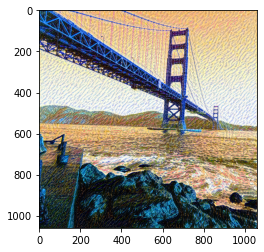

In [ ]:
import PIL
tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
tensor =  PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
#plt.imshow(tensor)